# Experiments

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [20]:
% matplotlib inline

import os
import sys
import glob
import tempfile

sys.path.append("..")

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d

from lime import lime_tabular as lt

from joblib import Memory

from libs import fourier_help

import pytff

pd.options.mode.chained_assignment = None 



## 1. Load Data

In [2]:
tile = pd.DataFrame(np.load("/home/data/carpyncho/stored/npy_tiles/cat_b278_jhk_1.npy"))

In [3]:
ogle3 = pd.read_table("../data/ogle_rr.txt", header=6)
ogle3.columns

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'# ID', u'Field', u'StarID', u'RA', u'Decl', u'Type', u'I', u'V',
       u'P_1', u'dP_1', u'T0_1', u'A_1', u'R21_1', u'phi21_1', u'R31_1',
       u'phi31_1', u'P_2', u'dP_2', u'T0_2', u'A_2', u'R21_2', u'phi21_2',
       u'R31_2', u'phi31_2', u'ID_OGLE_II', u'ID_MACHO', u'ID_GCVS',
       u'ID_OTHER', u'Remarks'],
      dtype='object')

In [4]:
path = "/home/data/carpyncho/stored/samples/b278_sample.npy"
df = pd.DataFrame(np.load(path))

In [5]:
obs = pd.read_pickle("../data/rrb278_obs.pkl")

##  2. Preprocess

### 2.1. Discretize the classes

In [15]:
classes = set(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

df["cls"] = df.ogle3_type.apply(classes.get)
df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
df=df[df.cls!=0]
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'Cep-1': 0,
 'Cep-F': 1,
 'LPV-Mira': 2,
 'LPV-OSARG': 3,
 'LPV-SRV': 4,
 'RRLyr-RRab': 5,
 'RRLyr-RRc': 6,
 'RRLyr-RRd': 7,
 'T2Cep-BLHer': 8,
 'T2Cep-RVTau': 9,
 'T2Cep-WVir': 10}

### Simplified Classes

{'Cep': 0, 'LPV': 1, 'RRLyr': 2, 'T2Cep': 3}

In [16]:
obs

,bm_src_id,pwp_stack_src_hjd,pwp_stack_src_mag3,pwp_stack_src_mag_err3
2198,32780000130429,56559.002017,14.790,0.064
2200,32780000131392,56559.002010,14.591,0.054
2930,32780000135858,56559.002009,14.367,0.044
3962,32780000143258,56559.002013,14.591,0.054
4973,32780000149862,56559.002012,14.278,0.041
5801,32780000155800,56559.002015,14.454,0.048
5981,32780000162422,56559.002022,14.884,0.070
8772,32780000176451,56559.002014,14.268,0.040
13985,32780000213091,56559.002028,13.967,0.031
14148,32780000214381,56559.002021,14.799,0.065


In [19]:


pd.DataFrame(np.load("/home/data/carpyncho/stored/matchs/b278/b278_v20100422_00647_st_cat.npy")).columns

Index([u'tile_name', u'tile_id', u'bm_src_id', u'bm_src_ra_h', u'bm_src_dec_h',
       u'bm_src_ra_j', u'bm_src_dec_j', u'bm_src_ra_k', u'bm_src_dec_k',
       u'bm_src_ogle3_type', u'bm_src_ogle3_id', u'pwp_stack_id',
       u'pwp_stack_band', u'pwp_stack_src_id', u'pwp_stack_src_hjd',
       u'pwp_stack_src_ra_deg', u'pwp_stack_src_dec_deg',
       u'pwp_stack_src_ra_h', u'pwp_stack_src_ra_m', u'pwp_stack_src_ra_s',
       u'pwp_stack_src_dec_d', u'pwp_stack_src_dec_m', u'pwp_stack_src_dec_s',
       u'pwp_stack_src_x', u'pwp_stack_src_y', u'pwp_stack_src_mag1',
       u'pwp_stack_src_mag_err1', u'pwp_stack_src_mag2',
       u'pwp_stack_src_mag_err2', u'pwp_stack_src_mag3',
       u'pwp_stack_src_mag_err3', u'pwp_stack_src_mag4',
       u'pwp_stack_src_mag_err4', u'pwp_stack_src_mag5',
       u'pwp_stack_src_mag_err5', u'pwp_stack_src_mag6',
       u'pwp_stack_src_mag_err6', u'pwp_stack_src_mag7',
       u'pwp_stack_src_mag_err7', u'pwp_stack_src_chip_nro',
       u'pwp_stack_src_ste

In [26]:
dis = []
for path in glob.glob("/home/data/carpyncho/stored/matchs/b278/*.npy"):
    arr = np.load("/home/data/carpyncho/stored/matchs/b278/b278_v20100422_00647_st_cat.npy")
    df = pd.DataFrame(
        arr[['bm_src_id', 'bm_src_ra_k', 'bm_src_dec_k', 'pwp_stack_src_ra_deg', 'pwp_stack_src_dec_deg']])
    df = df[df.bm_src_id.isin(obs.bm_src_id)]
    dis.append(df)
    

In [30]:
dis = pd.concat(dis)

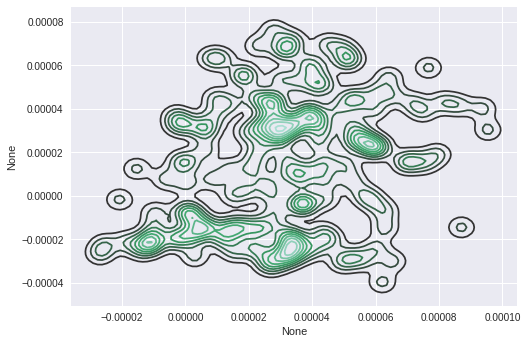

In [33]:
sns.kdeplot(dis.bm_src_ra_k - dis.pwp_stack_src_ra_deg, dis.bm_src_dec_k-dis.pwp_stack_src_dec_deg)

In [36]:
dis["euc"] = (dis.bm_src_ra_k - dis.pwp_stack_src_ra_deg) ** 2 + (dis.bm_src_dec_k-dis.pwp_stack_src_dec_deg) ** 2

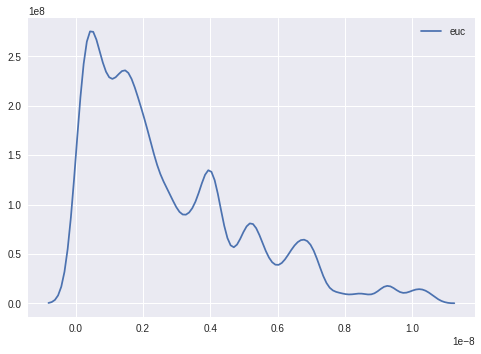

In [37]:
sns.kdeplot(dis.euc)

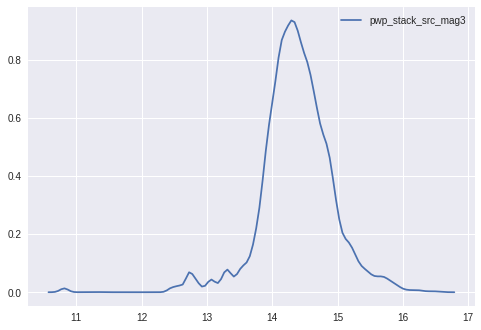

In [39]:
sns.kdeplot(obs.pwp_stack_src_mag3)